# Libraries

first, we will import all the libraries we will need later on.

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, f1_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
import numpy as np
from sklearn.utils import compute_class_weight
from keras.src.layers import Dense,Dropout
from keras import Sequential
from keras.src.callbacks import EarlyStopping
from imblearn.under_sampling import RandomUnderSampler
from keras.models import load_model

# Loading the processed Data

Next, we load the dataset we have worked on in preprocessing notebook.

In [59]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')['Class']
y_test = pd.read_csv('y_test.csv')['Class']


One of the major challenges in credit card fraud detection is the highly imbalanced class distribution. Therefore, it is important to prevent the model from becoming biased toward the majority class and ensure that it can effectively learn patterns associated with the minority class. In this notebook, we explore several solutions to find the best combination of hyperparameters and algorithms.

# Oversampling/Undersampling
We are going to explore three sets of training data:
- The original imbalanced training data
- Oversampled training data
- Undersampled training data

We use *SMOTE* (Synthetic Minority Oversampling Technique) Algorithm for oversampling which is an oversampling method for imbalanced datasets. It creates synthetic minority class samples by interpolating between existing ones and their nearest neighbors, balancing the dataset to improve model performance without simply duplicating data.

![credit : https://www.google.com/url?sa=i&url=https%3A%2F%2Fpub.aimind.so%2Fsynthetic-minority-over-sampling-technique-smote-empowering-ai-through-imbalanced-data-handling-d86f4de32ea3&psig=AOvVaw3VxNyFvCIVrxpdphD8Yz9O&ust=1753288171479000&source=images&cd=vfe&opi=89978449&ved=0CBgQjhxqFwoTCKCMqsjx0I4DFQAAAAAdAAAAABAM](https://miro.medium.com/v2/resize:fit:850/1*QaNfJwU6P-VnG1zp3U4cVg.png)


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Undersampling reduces majority class samples to balance the dataset, typically by randomly removing samples. It’s simpler but risks losing important data.

In [77]:
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Class Weights
Class weights address imbalanced data by assigning higher weights to the minority class in the loss function, making misclassifications of the minority class more costly. This is especially important in fraud detection tasks, where misclassifying fraudulent transactions can be extremely costly. Therefore, using class weights is crucial here.

In [78]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Training

Now, it's time to define the neural network architecture. We will start with a simple and stable feedforward structure, adding dropout to each layer to prevent overfitting and increase the model's robustness.

We use early stopping to prevent the model from overfitting and to save training time.


In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [57]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(227604, 30)
(227604,)
(56902, 30)
(56902,)


Now it's time to train our model on the three training sets to see which one performs best.

In [79]:
datasets = [
    ('original', X_train, y_train, class_weight_dict),
    ('smote', X_train_smote, y_train_smote, None),  # No class weights for SMOTE as it's balanced
    ('undersampled', X_train_under, y_train_under, None)  # No class weights for undersampled as it's balanced
]
batches = [32, 64, 128, 256]

We define a simple wrapper function to create the model based on the shape of the training data.

In [ ]:
def create_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['f1_score','precision'])
    return model

Now, we use the function defined above to train our models and save them for future use.

In [82]:
for dataset_name, X_data, y_data, class_weights in datasets:
    for batch in batches:
        print(f'\nTraining neural network with dataset: {dataset_name}, batch size: {batch}')

        model = create_model(X_data.shape[1])

        history = model.fit(
            X_data, y_data,
            epochs=50,
            batch_size=batch,
            validation_split=0.2,
            class_weight=class_weights,
            callbacks=[early_stopping],
            verbose=1
        )

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        print(f"\nClassification Report (dataset: {dataset_name}, batch size: {batch}):")
        print(classification_report(y_test, y_pred))
        print(f"\nConfusion Matrix (dataset: {dataset_name}, batch size: {batch}):")
        print(confusion_matrix(y_test, y_pred))

        model_name = f'model_{dataset_name}_batch{batch}.h5'
        model.save(model_name)
        print(f"Model saved as {model_name}")


Training neural network with dataset: original, batch size: 32
Epoch 1/50
5691/5691 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - f1_score: 0.0034 - loss: 0.9081 - precision: 0.0445 - val_f1_score: 0.0033 - val_loss: 0.1285 - val_precision: 0.0453
Epoch 2/50
5691/5691 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - f1_score: 0.0041 - loss: 0.2318 - precision: 0.0285 - val_f1_score: 0.0033 - val_loss: 0.1011 - val_precision: 0.0451
Epoch 3/50
5691/5691 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - f1_score: 0.0034 - loss: 0.1726 - precision: 0.0447 - val_f1_score: 0.0033 - val_loss: 0.1839 - val_precision: 0.0267
Epoch 4/50
5691/5691 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - f1_score: 0.0036 - loss: 0.1615 - precision: 0.0356 - val_f1_score: 0.0033 - val_loss: 0.0856 - val_precision: 0.1106
Epoch 5/50
5691/5691 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - f1_score: 0.0036 - loss: 0.1841 - precision: 0.0412 - val_f1_score: 0.0033 - val_loss: 0.1310 - val_precision: 0.0413
Epoch 6/50
5691/5691 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - f1_s


Classification Report (dataset: original, batch size: 32):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56825
           1       0.07      0.87      0.14        77

    accuracy                           0.99     56902
   macro avg       0.54      0.93      0.56     56902
weighted avg       1.00      0.99      0.99     56902


Confusion Matrix (dataset: original, batch size: 32):
[[55990   835]
 [   10    67]]
Model saved as model_original_batch32.h5

Training neural network with dataset: original, batch size: 64
Epoch 1/50
2846/2846 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - f1_score: 0.0039 - loss: 1.0646 - precision: 0.0226 - val_f1_score: 0.0033 - val_loss: 0.0674 - val_precision: 0.0932
Epoch 2/50
2846/2846 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.0033 - loss: 0.2581 - precision: 0.0248 - val_f1_score: 0.0033 - val_loss: 0.1039 - val_precision: 0.0600
Epoch 3/50
2846/2846 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - f1_score: 0.0038


Classification Report (dataset: original, batch size: 64):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56825
           1       0.07      0.86      0.13        77

    accuracy                           0.98     56902
   macro avg       0.54      0.92      0.56     56902
weighted avg       1.00      0.98      0.99     56902


Confusion Matrix (dataset: original, batch size: 64):
[[55973   852]
 [   11    66]]
Model saved as model_original_batch64.h5

Training neural network with dataset: original, batch size: 128
Epoch 1/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.0038 - loss: 1.2722 - precision: 0.0196 - val_f1_score: 0.0033 - val_loss: 0.1092 - val_precision: 0.0685
Epoch 2/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - f1_score: 0.0036 - loss: 0.2523 - precision: 0.0267 - val_f1_score: 0.0033 - val_loss: 0.0920 - val_precision: 0.0847
Epoch 3/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - f1_score: 0.0036


Classification Report (dataset: original, batch size: 128):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56825
           1       0.09      0.87      0.17        77

    accuracy                           0.99     56902
   macro avg       0.55      0.93      0.58     56902
weighted avg       1.00      0.99      0.99     56902


Confusion Matrix (dataset: original, batch size: 128):
[[56160   665]
 [   10    67]]
Model saved as model_original_batch128.h5

Training neural network with dataset: original, batch size: 256
Epoch 1/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - f1_score: 0.0042 - loss: 0.7244 - precision: 0.0107 - val_f1_score: 0.0033 - val_loss: 0.1724 - val_precision: 0.0783
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - f1_score: 0.0035 - loss: 0.2299 - precision: 0.0397 - val_f1_score: 0.0033 - val_loss: 0.1074 - val_precision: 0.0912
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - f1_score: 0.0037 - l


Classification Report (dataset: original, batch size: 256):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56825
           1       0.11      0.86      0.20        77

    accuracy                           0.99     56902
   macro avg       0.56      0.92      0.60     56902
weighted avg       1.00      0.99      0.99     56902


Confusion Matrix (dataset: original, batch size: 256):
[[56293   532]
 [   11    66]]
Model saved as model_original_batch256.h5

Training neural network with dataset: smote, batch size: 32
Epoch 1/50
11360/11360 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - f1_score: 0.6221 - loss: 0.0888 - precision: 0.9569 - val_f1_score: 1.0000 - val_loss: 0.0076 - val_precision: 1.0000
Epoch 2/50
11360/11360 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - f1_score: 0.8824 - loss: 0.0145 - precision: 0.9928 - val_f1_score: 1.0000 - val_loss: 0.0021 - val_precision: 1.0000
Epoch 3/50
11360/11360 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - f1_score:


Classification Report (dataset: smote, batch size: 32):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56825
           1       0.59      0.81      0.68        77

    accuracy                           1.00     56902
   macro avg       0.80      0.90      0.84     56902
weighted avg       1.00      1.00      1.00     56902


Confusion Matrix (dataset: smote, batch size: 32):
[[56782    43]
 [   15    62]]
Model saved as model_smote_batch32.h5

Training neural network with dataset: smote, batch size: 64
Epoch 1/50
5680/5680 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - f1_score: 0.5892 - loss: 0.1098 - precision: 0.9469 - val_f1_score: 1.0000 - val_loss: 0.0062 - val_precision: 1.0000
Epoch 2/50
5680/5680 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - f1_score: 0.8452 - loss: 0.0156 - precision: 0.9920 - val_f1_score: 1.0000 - val_loss: 0.0026 - val_precision: 1.0000
Epoch 3/50
5680/5680 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - f1_score: 0.9057 - loss: 0.


Classification Report (dataset: smote, batch size: 64):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56825
           1       0.59      0.79      0.68        77

    accuracy                           1.00     56902
   macro avg       0.80      0.90      0.84     56902
weighted avg       1.00      1.00      1.00     56902


Confusion Matrix (dataset: smote, batch size: 64):
[[56783    42]
 [   16    61]]
Model saved as model_smote_batch64.h5

Training neural network with dataset: smote, batch size: 128
Epoch 1/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - f1_score: 0.5644 - loss: 0.1594 - precision: 0.9268 - val_f1_score: 1.0000 - val_loss: 0.0152 - val_precision: 1.0000
Epoch 2/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - f1_score: 0.7738 - loss: 0.0212 - precision: 0.9884 - val_f1_score: 1.0000 - val_loss: 0.0038 - val_precision: 1.0000
Epoch 3/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - f1_score: 0.8816 - loss: 0


Classification Report (dataset: smote, batch size: 128):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56825
           1       0.57      0.79      0.66        77

    accuracy                           1.00     56902
   macro avg       0.78      0.90      0.83     56902
weighted avg       1.00      1.00      1.00     56902


Confusion Matrix (dataset: smote, batch size: 128):
[[56779    46]
 [   16    61]]
Model saved as model_smote_batch128.h5

Training neural network with dataset: smote, batch size: 256
Epoch 1/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - f1_score: 0.5527 - loss: 0.2018 - precision: 0.8828 - val_f1_score: 1.0000 - val_loss: 0.0196 - val_precision: 1.0000
Epoch 2/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - f1_score: 0.7030 - loss: 0.0268 - precision: 0.9869 - val_f1_score: 1.0000 - val_loss: 0.0066 - val_precision: 1.0000
Epoch 3/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - f1_score: 0.8284 - loss: 0


Classification Report (dataset: smote, batch size: 256):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56825
           1       0.64      0.78      0.70        77

    accuracy                           1.00     56902
   macro avg       0.82      0.89      0.85     56902
weighted avg       1.00      1.00      1.00     56902


Confusion Matrix (dataset: smote, batch size: 256):
[[56791    34]
 [   17    60]]
Model saved as model_smote_batch256.h5

Training neural network with dataset: undersampled, batch size: 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - f1_score: 0.5339 - loss: 1.0309 - precision: 0.4321 - val_f1_score: 1.0000 - val_loss: 0.2185 - val_precision: 1.0000
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - f1_score: 0.5530 - loss: 0.6092 - precision: 0.5464 - val_f1_score: 1.0000 - val_loss: 0.2368 - val_precision: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.5343 - loss: 0.4748


Classification Report (dataset: undersampled, batch size: 32):
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     56825
           1       0.00      0.83      0.01        77

    accuracy                           0.73     56902
   macro avg       0.50      0.78      0.43     56902
weighted avg       1.00      0.73      0.84     56902


Confusion Matrix (dataset: undersampled, batch size: 32):
[[41508 15317]
 [   13    64]]
Model saved as model_undersampled_batch32.h5

Training neural network with dataset: undersampled, batch size: 64
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - f1_score: 0.5317 - loss: 1.4896 - precision: 0.3136 - val_f1_score: 1.0000 - val_loss: 0.8074 - val_precision: 1.0000
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score: 0.5261 - loss: 0.8938 - precision: 0.5370 - val_f1_score: 1.0000 - val_loss: 0.3556 - val_precision: 1.0000
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score: 0


Classification Report (dataset: undersampled, batch size: 64):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56825
           1       0.05      0.84      0.09        77

    accuracy                           0.98     56902
   macro avg       0.52      0.91      0.54     56902
weighted avg       1.00      0.98      0.99     56902


Confusion Matrix (dataset: undersampled, batch size: 64):
[[55502  1323]
 [   12    65]]
Model saved as model_undersampled_batch64.h5

Training neural network with dataset: undersampled, batch size: 128
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - f1_score: 0.5459 - loss: 0.7011 - precision: 0.4210 - val_f1_score: 1.0000 - val_loss: 0.2446 - val_precision: 1.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - f1_score: 0.5321 - loss: 0.6426 - precision: 0.4455 - val_f1_score: 1.0000 - val_loss: 0.2114 - val_precision: 1.0000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - f1_score: 0.551


Classification Report (dataset: undersampled, batch size: 128):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56825
           1       0.02      0.86      0.04        77

    accuracy                           0.94     56902
   macro avg       0.51      0.90      0.50     56902
weighted avg       1.00      0.94      0.97     56902


Confusion Matrix (dataset: undersampled, batch size: 128):
[[53558  3267]
 [   11    66]]
Model saved as model_undersampled_batch128.h5

Training neural network with dataset: undersampled, batch size: 256
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - f1_score: 0.5580 - loss: 1.2079 - precision: 0.3171 - val_f1_score: 1.0000 - val_loss: 0.7125 - val_precision: 1.0000
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1_score: 0.5565 - loss: 0.9271 - precision: 0.3529 - val_f1_score: 1.0000 - val_loss: 0.3482 - val_precision: 1.0000
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1_score: 0.


Classification Report (dataset: undersampled, batch size: 256):
              precision    recall  f1-score   support

           0       1.00      0.54      0.70     56825
           1       0.00      0.90      0.01        77

    accuracy                           0.54     56902
   macro avg       0.50      0.72      0.35     56902
weighted avg       1.00      0.54      0.70     56902


Confusion Matrix (dataset: undersampled, batch size: 256):
[[30838 25987]
 [    8    69]]
Model saved as model_undersampled_batch256.h5


# Evaluation

Now, let's load the saved models and evaluate their performance. We also tuned the optimal threshold for the sigmoid function in the final layer.

In [94]:
results = []
for dataset_name,_,_,_ in datasets:
    for batch in batches:
        model_name = f'model_{dataset_name}_batch{batch}.h5'
        model = load_model(model_name)
        thresholds = [0.3, 0.4, 0.5]
        for threshold in thresholds:
             y_pred = (model.predict(X_test) > threshold).astype(int).flatten()
             precision = precision_score(y_test, y_pred, pos_label=1)
             f1 = f1_score(y_test, y_pred, pos_label=1)
             results.append({
                'dataset': dataset_name,
                'batch_size': batch,
                'precision': precision,
                'f1_score': f1,
                'threshold': threshold
            })
             print(f"\nMetrics for dataset: {dataset_name}, batch size: {batch}, threshold: {threshold}")
             print(f"Precision: {precision:.4f}")
             print(f"F1-Score: {f1:.4f}")

1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: original, batch size: 32, threshold: 0.3
Precision: 0.0488
F1-Score: 0.0924
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: original, batch size: 32, threshold: 0.4
Precision: 0.0601
F1-Score: 0.1125
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: original, batch size: 32, threshold: 0.5
Precision: 0.0743
F1-Score: 0.1369
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: original, batch size: 64, threshold: 0.3
Precision: 0.0323
F1-Score: 0.0623
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Metrics for dataset: original, batch size: 64, threshold: 0.4
Precision: 0.0476
F1-Score: 0.0902
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: original, batch size: 64, threshold: 0.5
Precision: 0.0719
F1-Score: 0.1327
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: original, batch size: 128, threshold: 0.3
Precision: 0.0629
F1-Score: 0.1174
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Metrics for dataset: original, batch size: 128, threshold: 0.4
Precision: 0.0754
F1-Score: 0.1387
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: original, batch size: 128, threshold: 0.5
Precision: 0.0915
F1-Score: 0.1656
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: original, batch size: 256, threshold: 0.3
Precision: 0.0578
F1-Score: 0.1083
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Metrics for dataset: original, batch size: 256, threshold: 0.4
Precision: 0.0811
F1-Score: 0.1481
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: original, batch size: 256, threshold: 0.5
Precision: 0.1104
F1-Score: 0.1956
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: smote, batch size: 32, threshold: 0.3
Precision: 0.5536
F1-Score: 0.6561
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: smote, batch size: 32, threshold: 0.4
Precision: 0.5688
F1-Score: 0.6667
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step



Metrics for dataset: smote, batch size: 32, threshold: 0.5
Precision: 0.5905
F1-Score: 0.6813
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: smote, batch size: 64, threshold: 0.3
Precision: 0.5304
F1-Score: 0.6354
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: smote, batch size: 64, threshold: 0.4
Precision: 0.5755
F1-Score: 0.6667
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: smote, batch size: 64, threshold: 0.5
Precision: 0.5922
F1-Score: 0.6778
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: smote, batch size: 128, threshold: 0.3
Precision: 0.5351
F1-Score: 0.6387
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: smote, batch size: 128, threshold: 0.4
Precision: 0.5495
F1-Score: 0.6489
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: smote, batch size: 128, threshold: 0.5
Precision: 0.5701
F1-Score: 0.6630
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: smote, batch size: 256, threshold: 0.3
Precision: 0.6162
F1-Score: 0.6932
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: smote, batch size: 256, threshold: 0.4
Precision: 0.6354
F1-Score: 0.7052
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: smote, batch size: 256, threshold: 0.5
Precision: 0.6383
F1-Score: 0.7018
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Metrics for dataset: undersampled, batch size: 32, threshold: 0.3
Precision: 0.0014
F1-Score: 0.0028
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: undersampled, batch size: 32, threshold: 0.4
Precision: 0.0016
F1-Score: 0.0033
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: undersampled, batch size: 32, threshold: 0.5
Precision: 0.0042
F1-Score: 0.0083
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: undersampled, batch size: 64, threshold: 0.3
Precision: 0.0030
F1-Score: 0.0060
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: undersampled, batch size: 64, threshold: 0.4
Precision: 0.0102
F1-Score: 0.0202
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: undersampled, batch size: 64, threshold: 0.5
Precision: 0.0468
F1-Score: 0.0887
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Metrics for dataset: undersampled, batch size: 128, threshold: 0.3
Precision: 0.0014
F1-Score: 0.0029
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: undersampled, batch size: 128, threshold: 0.4
Precision: 0.0026
F1-Score: 0.0053
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Metrics for dataset: undersampled, batch size: 128, threshold: 0.5
Precision: 0.0198
F1-Score: 0.0387
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

Metrics for dataset: undersampled, batch size: 256, threshold: 0.3
Precision: 0.0014
F1-Score: 0.0027
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

Metrics for dataset: undersampled, batch size: 256, threshold: 0.4
Precision: 0.0014
F1-Score: 0.0028
1779/1779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics for dataset: undersampled, batch size: 256, threshold: 0.5
Precision: 0.0026
F1-Score: 0.0053


Now, we plot the models’ performances based on their F1 scores to compare them.


Results Table:
         dataset  batch_size  precision  f1_score  threshold
0       original          32   0.048798  0.092414        0.3
1       original          32   0.060144  0.112510        0.4
2       original          32   0.074279  0.136874        0.5
3       original          64   0.032289  0.062268        0.3
4       original          64   0.047619  0.090226        0.4
5       original          64   0.071895  0.132663        0.5
6       original         128   0.062905  0.117444        0.3
7       original         128   0.075366  0.138716        0.4
8       original         128   0.091530  0.165637        0.5
9       original         256   0.057793  0.108285        0.3
10      original         256   0.081081  0.148148        0.4
11      original         256   0.110368  0.195556        0.5
12         smote          32   0.553571  0.656085        0.3
13         smote          32   0.568807  0.666667        0.4
14         smote          32   0.590476  0.681319        0.5
15      

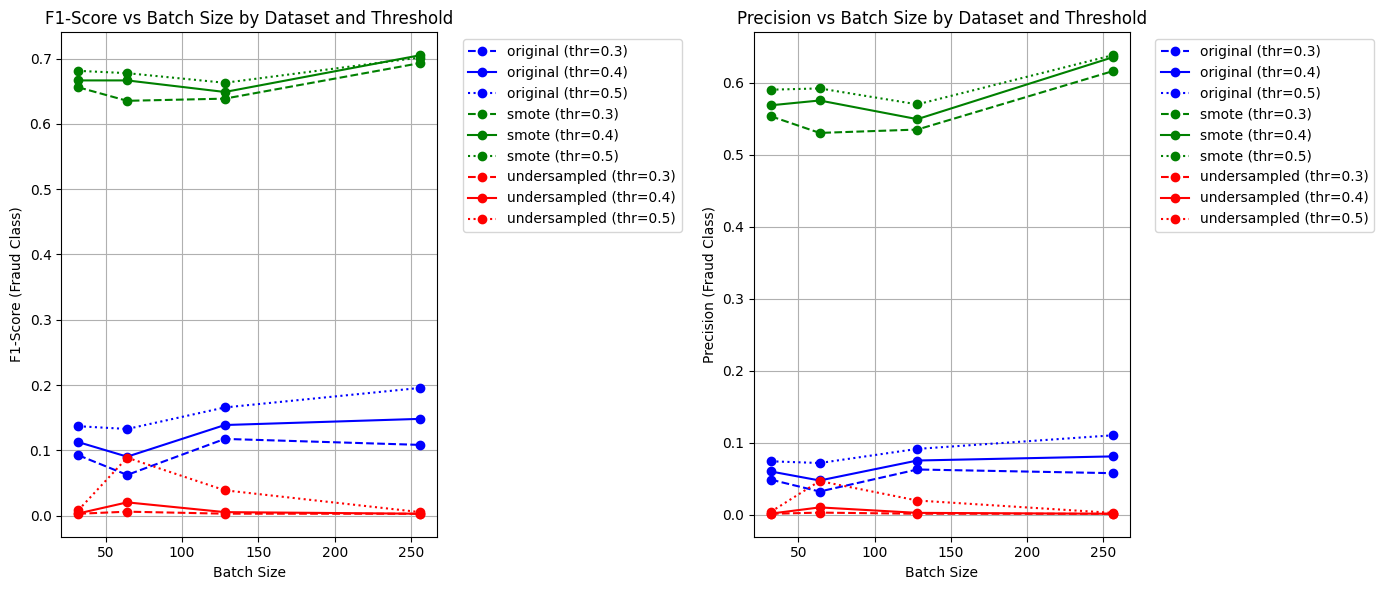


Plot saved as 'model_comparison_plot.png'


In [107]:
print("\nResults Table:")
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(14, 6))

line_styles = {0.3: '--', 0.4: '-', 0.5: ':'}
colors = {'original': 'blue', 'smote': 'green', 'undersampled': 'red'}

plt.subplot(1, 2, 1)
for dataset_name in results_df['dataset'].unique():
    for threshold in thresholds:
        subset = results_df[(results_df['dataset'] == dataset_name) & (results_df['threshold'] == threshold)]
        if not subset.empty:
            plt.plot(
                subset['batch_size'],
                subset['f1_score'],
                marker='o',
                linestyle=line_styles[threshold],
                color=colors[dataset_name],
                label=f'{dataset_name} (thr={threshold})'
            )
plt.xlabel('Batch Size')
plt.ylabel('F1-Score (Fraud Class)')
plt.title('F1-Score vs Batch Size by Dataset and Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
for dataset_name in results_df['dataset'].unique():
    for threshold in thresholds:
        subset = results_df[(results_df['dataset'] == dataset_name) & (results_df['threshold'] == threshold)]
        if not subset.empty:
            plt.plot(
                subset['batch_size'],
                subset['precision'],
                marker='o',
                linestyle=line_styles[threshold],
                color=colors[dataset_name],
                label=f'{dataset_name} (thr={threshold})'
            )
plt.xlabel('Batch Size')
plt.ylabel('Precision (Fraud Class)')
plt.title('Precision vs Batch Size by Dataset and Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.savefig('model_comparison_plot.png')
plt.close()

print("\nPlot saved as 'model_comparison_plot.png'")

As we can see, oversampling had a significant impact on the model’s accuracy by helping it learn features of the minority class. On the other hand, undersampling may have caused the loss of many important data points.

In [1]:
model = load_model('model_comparison_plot.h5')

NameError: name 'load_model' is not defined